# Why?

After reviewing this solution that seems to be very good at predicting survival, i'll make some changes to what i did initially. Also, i discovered some stuff about the data after EDA1, so we'll re-look at that. I thought SibSp and Parch were 0/1 fields, which they are not!  

Things to look at here: 
- explore SibSp & Parch further 
- dig into titles and if they matter
- don't bother with marking missing columns (just see how this goes and whether it makes a difference)
- KNN was the best algorithme, so maybe different data normalization approaches (e.g. standard scaler vs. min-max) would do better. 



In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# need this to be able to import processor module
import os
import sys
sys.path.insert(0, os.path.abspath('../modules'))
import preprocess as pp

In [2]:
df_raw = pd.read_csv("../data/train.csv")

df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_raw.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Cleanup

- Do the data manipulation that'll make things easier before filling in age or figuring out what to do with missing cabin
- Do not add the <label>_is_missing columns
- Split out last name and title

In [6]:
df = df_raw.copy()
df["Family"] = df.SibSp+df.Parch
df.Embarked.fillna("X", inplace=True)
df[['LastName','TitleFirstName']] = df.Name.str.split(',', expand=True)
df['Title'] = df.TitleFirstName.apply(lambda x: x.split('.') [0])
df = df.drop(['Name', 'SibSp', "Parch", 'TitleFirstName'], axis=1)

df["TicketSurvivalRate"] = .5
for ticket, travel_group in df.groupby('Ticket'):
    if (len(travel_group) > 5):
        df.loc[df.Ticket == ticket, 'TicketSurvivalRate'] = travel_group.Survived.mean()
        
df = pp.infer_cabin_features(df, mark_missing=False)

df.isna().sum()

1601 74     0.714286
169    0.714286
509    0.714286
643    0.714286
692    0.714286
826    0.714286
838    0.714286
Name: TicketSurvivalRate, dtype: float64
3101295 50     0.0
164    0.0
266    0.0
638    0.0
686    0.0
824    0.0
Name: TicketSurvivalRate, dtype: float64
347082 13     0.0
119    0.0
541    0.0
542    0.0
610    0.0
813    0.0
850    0.0
Name: TicketSurvivalRate, dtype: float64
347088 63     0.0
167    0.0
360    0.0
634    0.0
642    0.0
819    0.0
Name: TicketSurvivalRate, dtype: float64
CA 2144 59     0.0
71     0.0
386    0.0
480    0.0
678    0.0
683    0.0
Name: TicketSurvivalRate, dtype: float64
CA. 2343 159    0.0
180    0.0
201    0.0
324    0.0
792    0.0
846    0.0
863    0.0
Name: TicketSurvivalRate, dtype: float64


PassengerId             0
Survived                0
Pclass                  0
Sex                     0
Age                   177
Ticket                  0
Fare                    0
Cabin                   0
Embarked                0
Family                  0
LastName                0
Title                   0
TicketSurvivalRate      0
Deck                    0
dtype: int64

In [7]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Family,LastName,Title,TicketSurvivalRate,Deck
0,1,0,3,male,22.0,A/5 21171,7.2500,unknown,S,1,Braund,Mr,0.5,unknown
1,2,1,1,female,38.0,PC 17599,71.2833,C85,C,1,Cumings,Mrs,0.5,C
2,3,1,3,female,26.0,STON/O2. 3101282,7.9250,unknown,S,0,Heikkinen,Miss,0.5,unknown
3,4,1,1,female,35.0,113803,53.1000,C123,S,1,Futrelle,Mrs,0.5,C
4,5,0,3,male,35.0,373450,8.0500,unknown,S,0,Allen,Mr,0.5,unknown


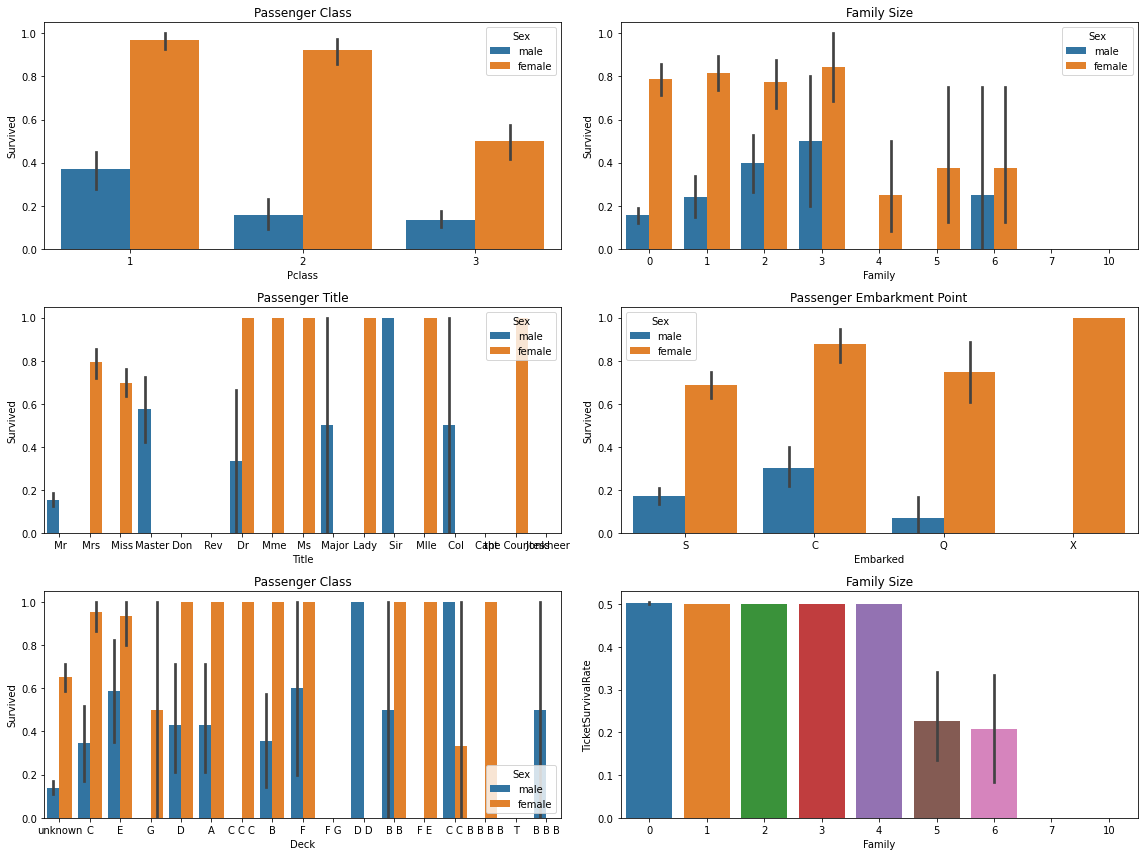

In [8]:
fig, ax = plt.subplots(figsize=(16,12), nrows=3, ncols=2)

# survival vs. Pclass
sns.barplot(data=df, x='Pclass', y='Survived', hue='Sex', ax=ax[0,0])
ax[0,0].set_title("Passenger Class")

# survival vs. Family
sns.barplot(data=df, x='Family', y='Survived', hue='Sex', ax=ax[0,1])
ax[0,1].set_title("Family Size")

# survival vs. Title
sns.barplot(data=df, x='Title', y='Survived', hue='Sex', ax=ax[1,0])
ax[1,0].set_title("Passenger Title")

# survival vs. Embarked
sns.barplot(data=df, x='Embarked', y='Survived', hue='Sex', ax=ax[1,1])
ax[1,1].set_title("Passenger Embarkment Point")


# survival vs. Deck
sns.barplot(data=df, x='Deck', y='Survived', hue='Sex', ax=ax[2,0])
ax[2,0].set_title("Passenger Class")

# survival vs. Ticket
sns.barplot(data=df, x='Family', y='TicketSurvivalRate', ax=ax[2,1])
ax[2,1].set_title("Family Size")

plt.tight_layout();

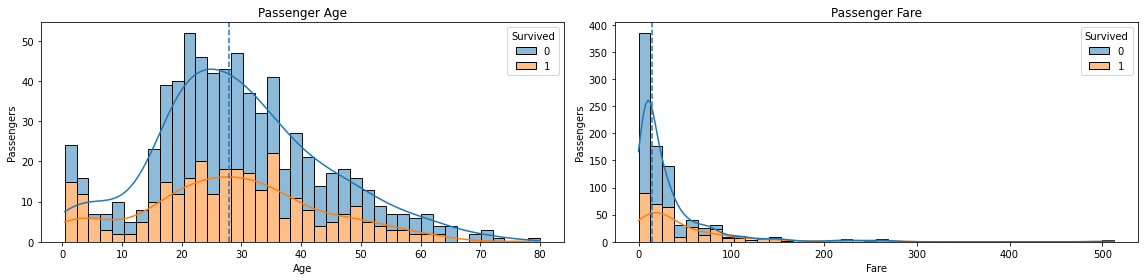

In [9]:
fig, ax = plt.subplots(figsize=(16,4), ncols=2)

# Age
sns.histplot(data=df, x='Age', hue='Survived', kde=True, multiple='stack', bins=40, ax=ax[0])
ax[0].axvline(df.Age.median(),linestyle="--" )
ax[0].set_title("Passenger Age")
ax[0].set_ylabel("Passengers")

# survival vs. Fare
sns.histplot(data=df, x='Fare', hue='Survived', kde=True, multiple='stack', bins=40, ax=ax[1])
ax[1].axvline(df.Fare.median(),linestyle="--" )
ax[1].set_title("Passenger Fare")
ax[1].set_ylabel("Passengers")


plt.tight_layout();

## Bucketing 

https://developers.google.com/machine-learning/data-prep/transform/bucketing

**Why do people split continuous variables into buckets?**
- test data can get sorted in the same buckets, even if its distribution isn't the same as the training data

**When that's appropriate to do?**
- when you want the test data to get organized based on the same boundaries as the train data, rather than split it into different buckets based on its own distribution. 

**What are the techniques involved?**
- you can set your own boundaries based on context. e.g. child == under 18. 
- you can use pandas quantile to divide based on fractions 
- you can do standard deviations...

In [17]:

age_cuts = [1, 2, 3, 4, 5, 6]
age_bucket_tops = df.Age.quantile(q=[.17, .34, .51, .68, .84, 1])
age_cut_bins = np.insert(age_bucket_tops.values, 0, 0, axis=0)


fare_cuts = [1, 2, 3, 4, 5, 6]
fare_bucket_tops = df.Fare.quantile(q=[.17, .34, .51, .68, .84, 1])
fare_cut_bins = np.insert(fare_bucket_tops.values, 0, 0, axis=0)

print(age_cut_bins)
print(fare_cut_bins)


[ 0.    18.    23.    28.815 35.    44.92  80.   ]
[  0.       7.775    8.6625  14.5     26.3075  53.1    512.3292]


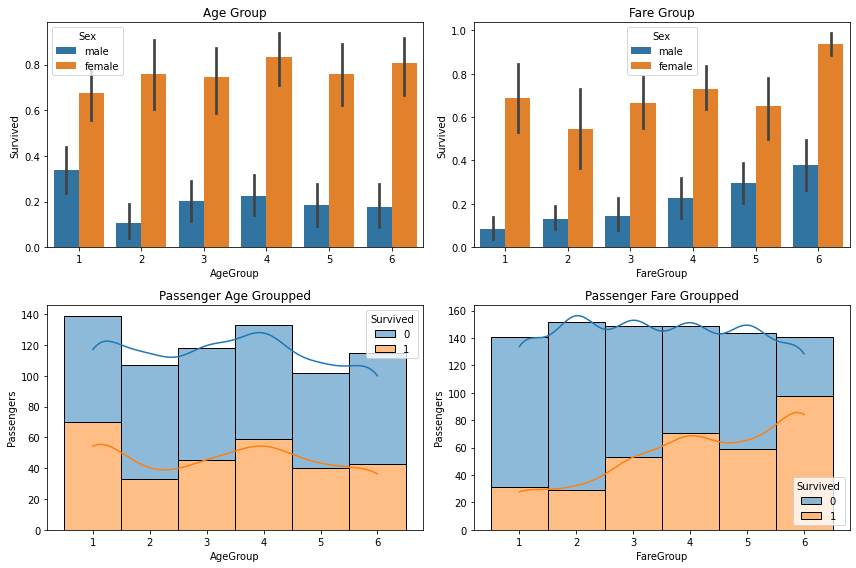

In [11]:
fig, ax = plt.subplots(figsize=(12,8), nrows=2, ncols=2)

from turtle import position
# break up ages and fares into differnt groups
# same as 
#    df = pp.set_age_groups(df)
#    df = pp.set_fare_groups(df)

df['AgeGroup'] = pd.cut(df['Age'], bins=age_cut_bins, labels = age_cuts)
df['FareGroup'] = pd.cut(df['Fare'], bins=fare_cut_bins, labels = fare_cuts)


# Age
sns.histplot(data=df, x='AgeGroup', hue='Survived', kde=True, multiple='stack', bins=6, ax=ax[1,0])
ax[1,0].set_title("Passenger Age Groupped")
ax[1,0].set_ylabel("Passengers")

# survival vs. Fare
sns.histplot(data=df, x='FareGroup', hue='Survived', kde=True, multiple='stack', bins=6, ax=ax[1,1])
ax[1,1].set_title("Passenger Fare Groupped")
ax[1,1].set_ylabel("Passengers")


# survival vs. Age Group
sns.barplot(data=df, x='AgeGroup', y='Survived', hue='Sex', ax=ax[0,0])
ax[0,0].set_title("Age Group")

# survival vs. Fare Group
sns.barplot(data=df, x='FareGroup', y='Survived', hue='Sex', ax=ax[0,1])
ax[0,1].set_title("Fare Group");

plt.tight_layout();

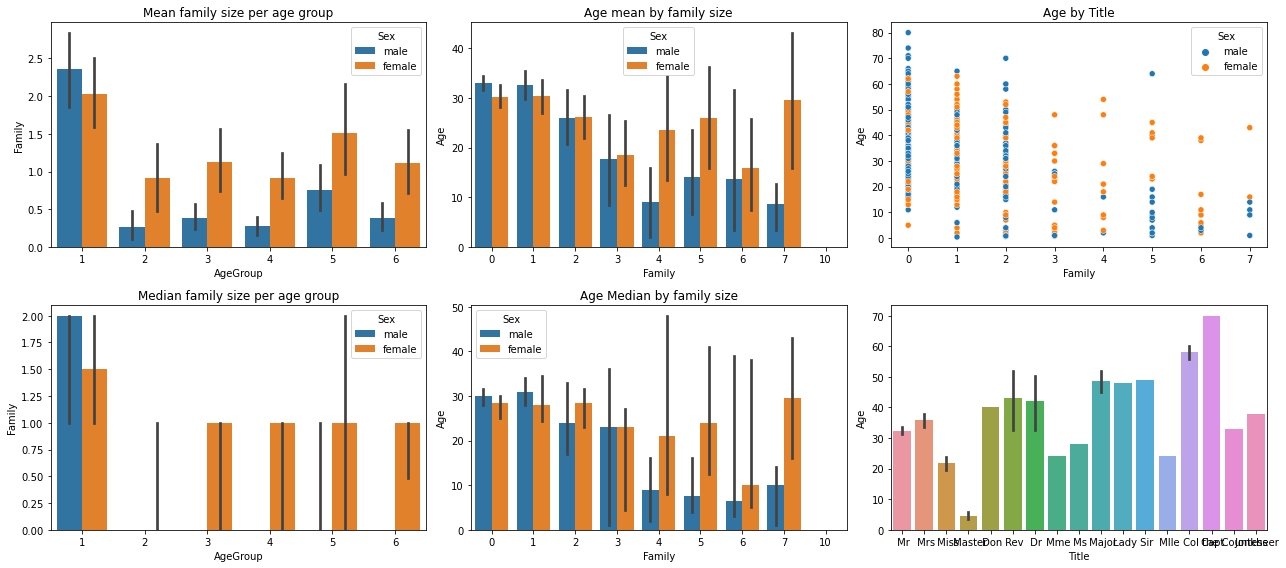

In [20]:
from inspect import stack
from numpy import median

fig, ax = plt.subplots(figsize=(18,8), ncols=3, nrows=2)

#  Family size vs. Age Group
sns.barplot(data=df, x='AgeGroup', y='Family',hue='Sex', ax=ax[0,0])
ax[0, 0].set_title("Mean family size per age group");

#  Age vs. Fam Size
sns.barplot(data=df, x='Family', y='Age',hue='Sex', ax=ax[0,1])
ax[0, 1].set_title("Age mean by family size");

sns.scatterplot(data=df, x='Family', y='Age', hue='Sex', ax=ax[0,2])
ax[0, 2].set_title("Age by family size");


#  Family size vs. Age Group
sns.barplot(data=df, x='AgeGroup', y='Family', hue='Sex',estimator=median, ax=ax[1,0])
ax[1, 0].set_title("Median family size per age group");

#  Age vs. Fam Size
sns.barplot(data=df, x='Family', y='Age', hue='Sex',estimator=median, ax=ax[1,1])
ax[1, 1].set_title("Age Median by family size");

sns.barplot(data=df, x='Title', y='Age', ax=ax[1,2])
ax[0, 2].set_title("Age by Title");
plt.tight_layout();


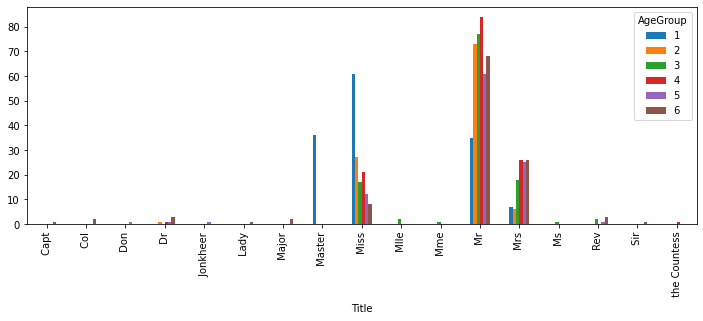

In [25]:
pd.crosstab(df.Title, df.AgeGroup).plot(kind="bar", figsize=(12,4));

In [13]:
df.drop(['LastName', 'Cabin' ], inplace=True, axis=1)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Family,Title,TicketSurvivalRate,Deck,AgeGroup,FareGroup
0,1,0,3,male,22.0,A/5 21171,7.2500,S,1,Mr,0.5,unknown,2,1
1,2,1,1,female,38.0,PC 17599,71.2833,C,1,Mrs,0.5,C,5,6
2,3,1,3,female,26.0,STON/O2. 3101282,7.9250,S,0,Miss,0.5,unknown,3,2
3,4,1,1,female,35.0,113803,53.1000,S,1,Mrs,0.5,C,4,5
4,5,0,3,male,35.0,373450,8.0500,S,0,Mr,0.5,unknown,4,2


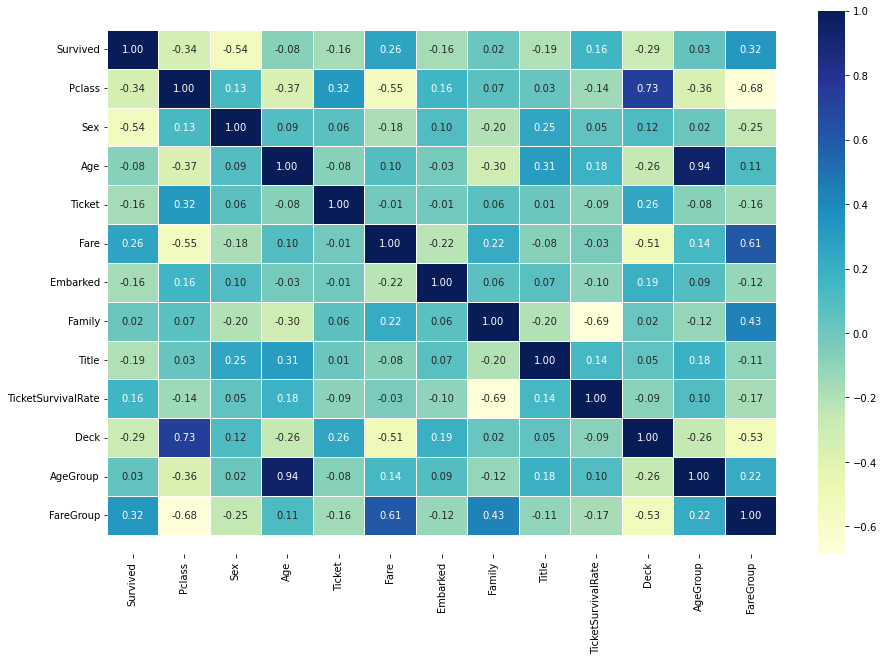

In [14]:
num_df = df.copy()
num_df = pp.numerify_categorical_columns_0(num_df, columns=["Sex", "Embarked", "Title", "Ticket", "Deck","FareGroup", "AgeGroup"])
num_df = num_df.drop("PassengerId", axis=1) # the passenger ID isn't descriptive, so there's no need to correlate with it. 

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(num_df.corr(), annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + .5, top - .5);

In [41]:
median_ages = np.zeros((2,10))

for sex in [0,1]:
    sex_median = num_df.loc[num_df.Sex == sex].Age.median()
    for family in np.arange(0, 10):
        pred_age = num_df.loc[((num_df.Family == family) & (num_df.Sex == sex))].Age.median()
        if pred_age > 0:
            median_ages[sex][family] = pred_age
            print(f"sex {sex}, fam {family} --> age {median_ages[sex][family]}")
        else:
            median_ages[sex][family] = sex_median
            print(f"sex {sex}, fam {family}* --> age {median_ages[sex][family]}")

median_ages

sex 0, fam 0 --> age 28.5
sex 0, fam 1 --> age 28.0
sex 0, fam 2 --> age 28.5
sex 0, fam 3 --> age 23.0
sex 0, fam 4 --> age 21.0
sex 0, fam 5 --> age 24.0
sex 0, fam 6 --> age 10.0
sex 0, fam 7 --> age 29.5
sex 0, fam 8* --> age 27.0
sex 0, fam 9* --> age 27.0
sex 1, fam 0 --> age 30.0
sex 1, fam 1 --> age 31.0
sex 1, fam 2 --> age 24.0
sex 1, fam 3 --> age 23.0
sex 1, fam 4 --> age 9.0
sex 1, fam 5 --> age 7.5
sex 1, fam 6 --> age 6.5
sex 1, fam 7 --> age 10.0
sex 1, fam 8* --> age 29.0
sex 1, fam 9* --> age 29.0


array([[28.5, 28. , 28.5, 23. , 21. , 24. , 10. , 29.5, 27. , 27. ],
       [30. , 31. , 24. , 23. ,  9. ,  7.5,  6.5, 10. , 29. , 29. ]])

In [15]:
num_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Family,Title,TicketSurvivalRate,Deck,AgeGroup,FareGroup
0,0,3,1,22.0,523,7.2500,2,1,11,0.5,16,1,0
1,1,1,0,38.0,596,71.2833,0,1,12,0.5,5,4,5
2,1,3,0,26.0,669,7.9250,2,0,8,0.5,16,2,1
3,1,1,0,35.0,49,53.1000,2,1,12,0.5,5,3,4
4,0,3,1,35.0,472,8.0500,2,0,11,0.5,16,3,1
